In [20]:
!pip install xgboost
!pip install imbalanced-learn
!pip install category_encoders

In [21]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import category_encoders as ce

from imblearn.over_sampling import SMOTE, SVMSMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
customer_data = pd.read_csv('/content/train.csv', delimiter=',')

#Data Overview

In [39]:
customer_data

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


In [ ]:
customer_data.dtypes

,0
state,object
account_length,int64
area_code,object
international_plan,object
voice_mail_plan,object
number_vmail_messages,int64
total_day_minutes,float64
total_day_calls,int64
total_day_charge,float64
total_eve_minutes,float64


In [ ]:
def reviewData(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(customer_data.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [ ]:
reviewData(customer_data, 'Overiew of the training dataset')

Overiew of the training dataset:

Rows: 4250

Number of features: 20

Features:
['state', 'account_length', 'area_code', 'international_plan', 'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls', 'churn']

Missing values: 0

Unique values:
state                              51
account_length                    215
area_code                           3
international_plan                  2
voice_mail_plan                     2
number_vmail_messages              46
total_day_minutes                1843
total_day_calls                   120
total_day_charge                 1843
total_eve_minutes                1773
total_eve_calls                   123
total_eve_charge                 1572
total_night_minutes            

# Exploratory Data Analysis

In [ ]:
import plotly.graph_objs as go # visualization
import plotly.offline as py # visualization

trace = go.Pie(labels = customer_data["churn"].value_counts().keys().tolist(),
               values = customer_data["churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','lime'],
                             line = dict(color = "white", width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer churn in training data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)


In [ ]:
object_cols = [x for x in customer_data.columns if customer_data[x].dtype == 'object']
print(object_cols)

['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']


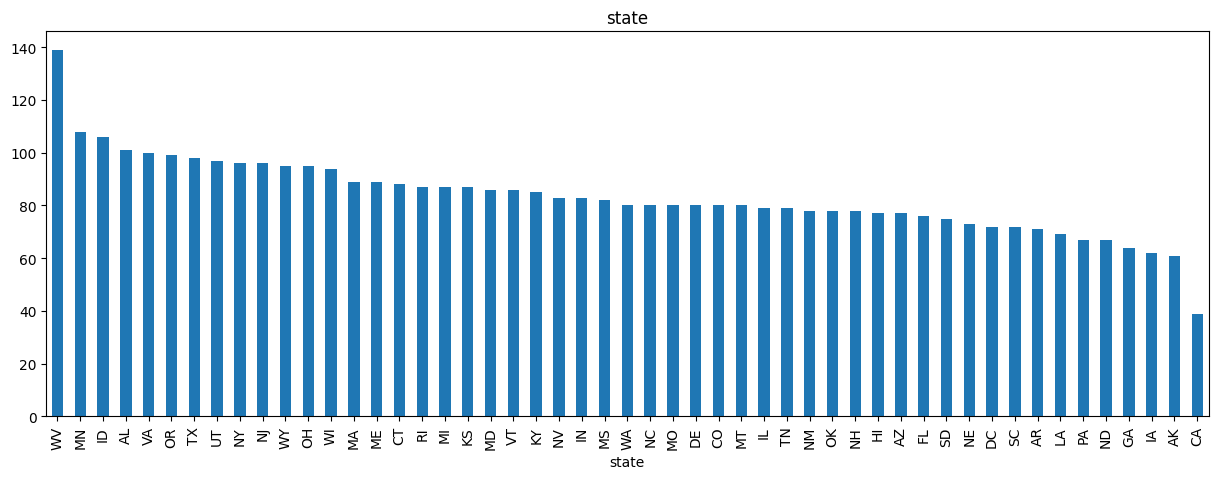

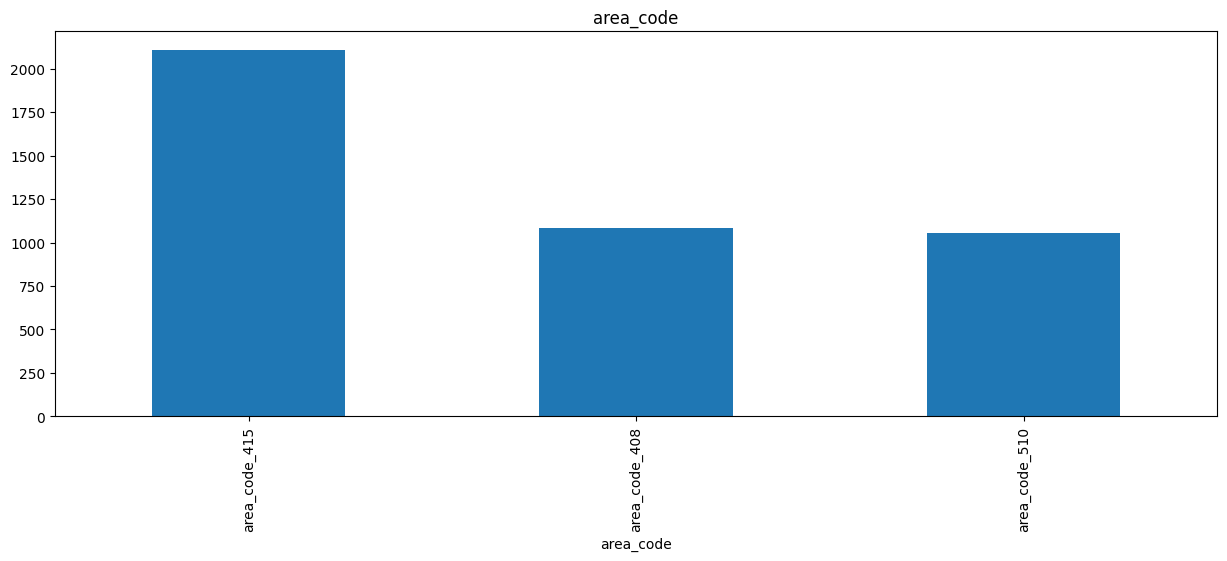

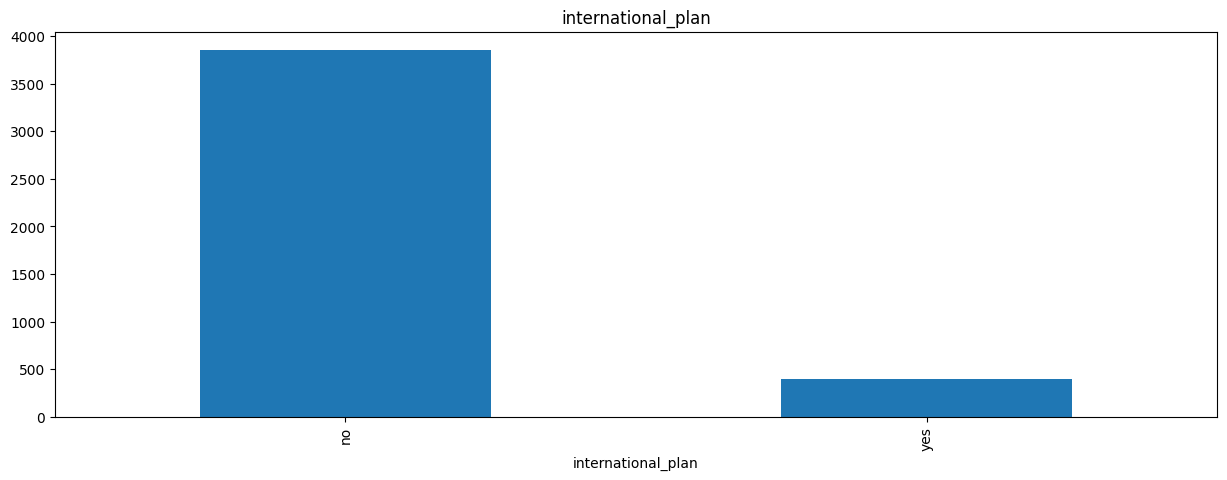

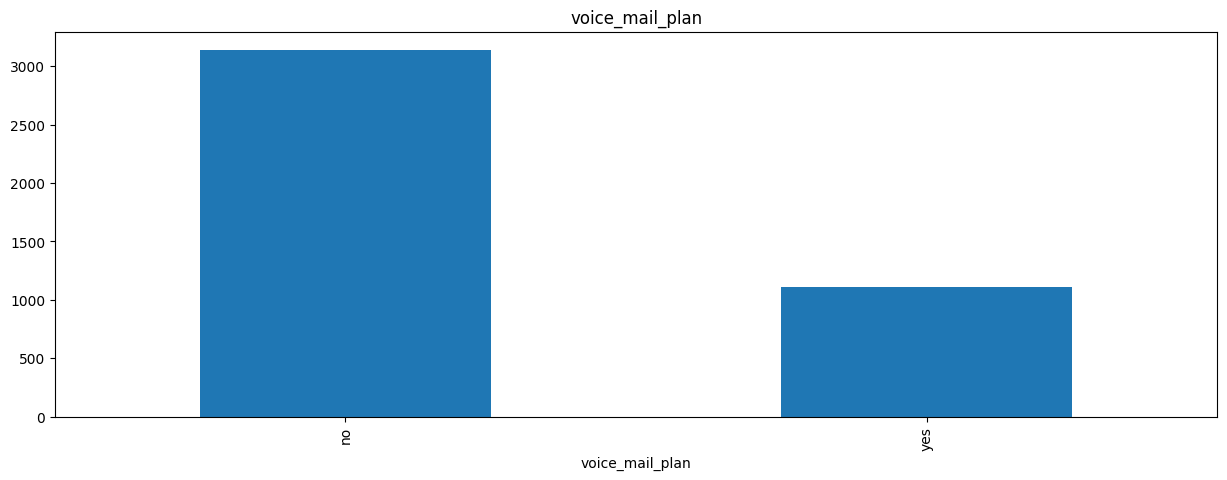

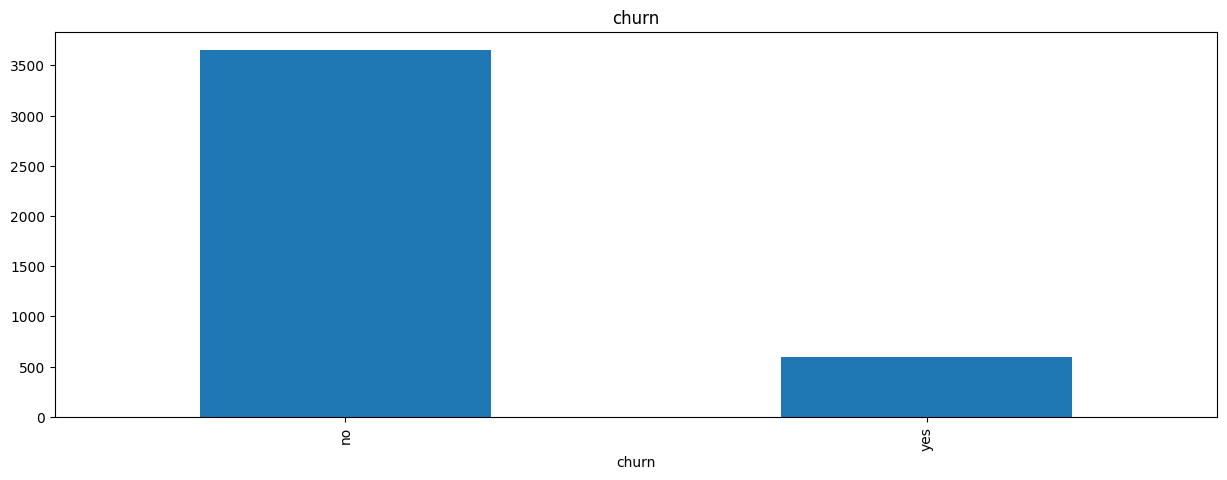

In [ ]:
for col in object_cols:
    customer_data[col].value_counts().plot(kind='bar', figsize=(15, 5))
    plt.title(col)
    plt.show()

In [ ]:
numeric_cols = [x for x in customer_data.columns if customer_data[x].dtype != 'object']
print(numeric_cols)

['account_length', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'number_customer_service_calls']


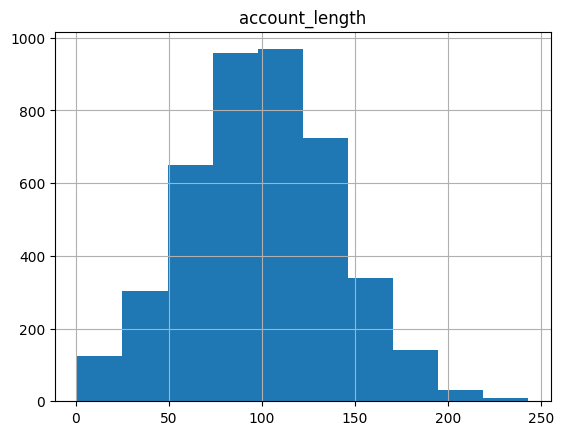

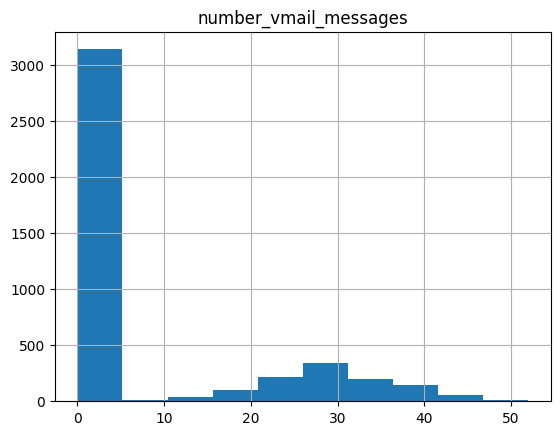

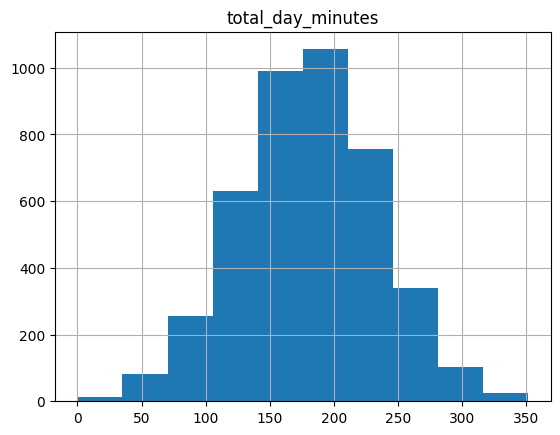

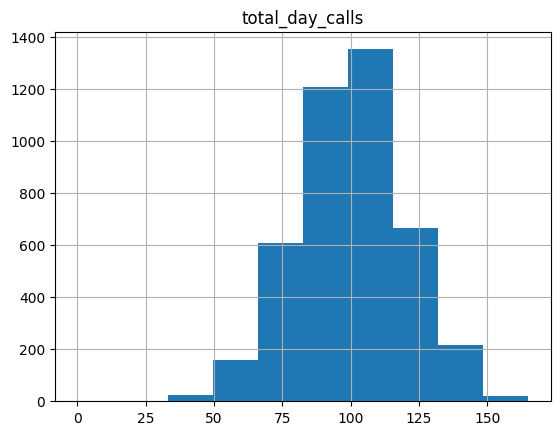

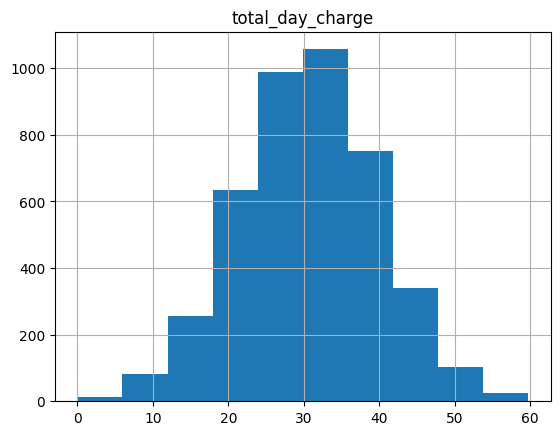

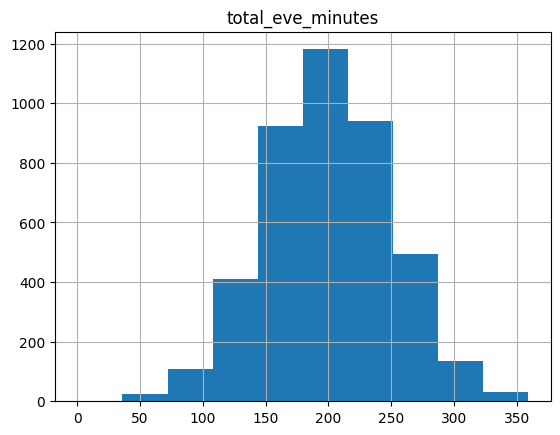

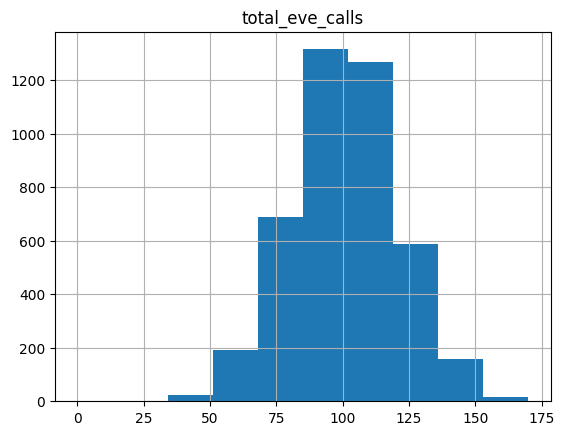

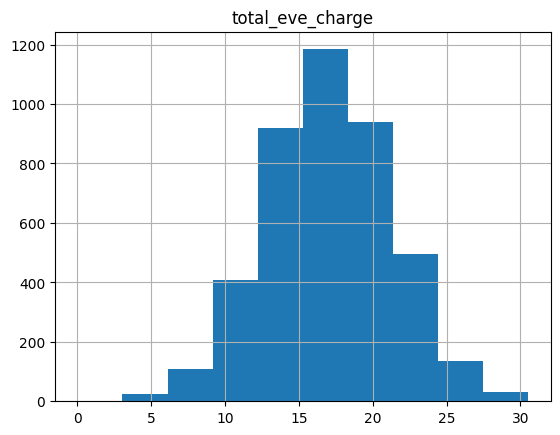

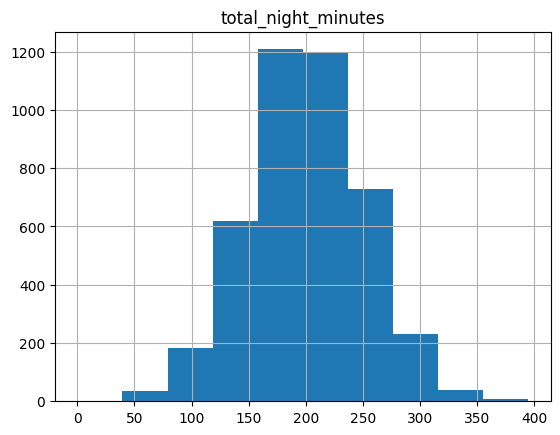

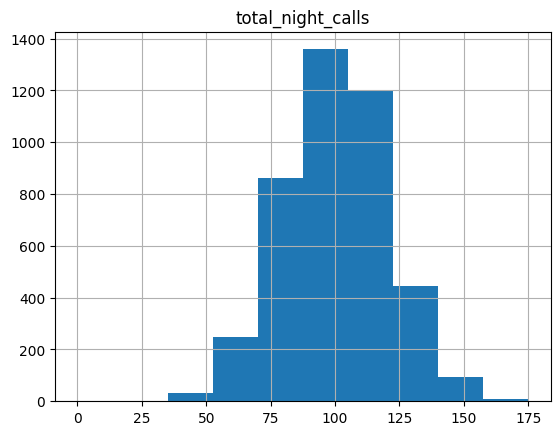

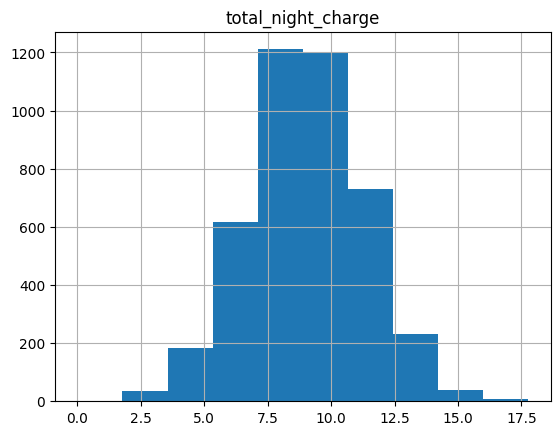

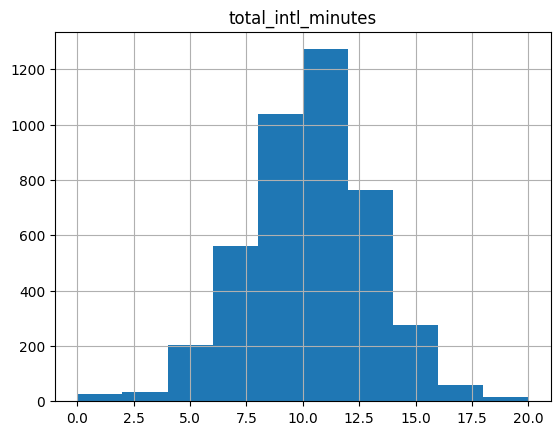

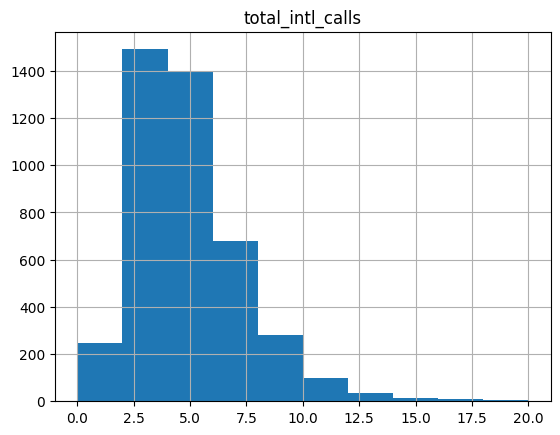

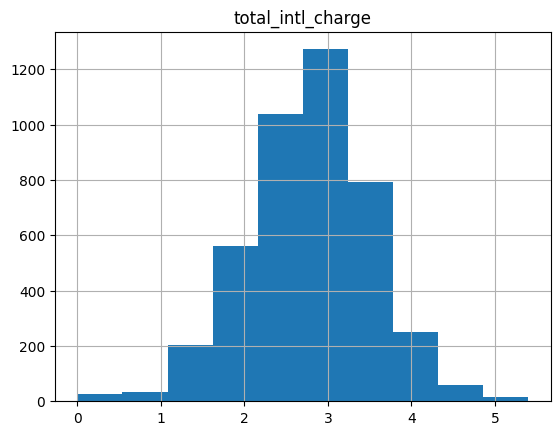

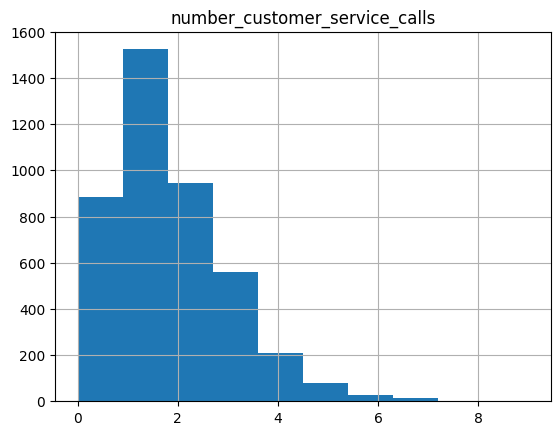

In [ ]:
for col in numeric_cols:
    customer_data[col].hist()
    plt.title(col)
    plt.show()

#Data Processing




In [40]:
#Remove correlated attribte not nessesarry
col_to_drop = ['state','area_code', 'total_day_charge', 'total_eve_charge',
               'total_night_charge', 'total_intl_charge']
customer_data.drop(columns= col_to_drop, axis=1, inplace=True)

In [ ]:
customer_data

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,107,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,no
1,137,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,no
2,84,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,no
3,75,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,no
4,121,no,yes,24,218.2,88,348.5,108,212.6,118,7.5,7,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,no,no,0,188.3,70,243.8,88,213.7,79,10.3,6,0,no
4246,73,no,no,0,177.9,89,131.2,82,186.2,89,11.5,6,3,no
4247,75,no,no,0,170.7,101,193.1,126,129.1,104,6.9,7,1,no
4248,50,no,yes,40,235.7,127,223.0,126,297.5,116,9.9,5,2,no


In [ ]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()} {df[column].value_counts()}')

In [24]:
print_unique_col_values(customer_data)

international_plan: ['no' 'yes'] international_plan
no     3854
yes     396
Name: count, dtype: int64
voice_mail_plan: ['yes' 'no'] voice_mail_plan
no     3138
yes    1112
Name: count, dtype: int64
churn: ['no' 'yes'] churn
no     3652
yes     598
Name: count, dtype: int64


In [41]:
#Chia tập dữ liệu
X = customer_data.drop(columns=["churn"], axis = 1)
y = customer_data["churn"]

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
# OneHot Encoder --> Encode Independent variable
X = pd.get_dummies(X, columns = ["international_plan","voice_mail_plan"])
X

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,True,False,False,True
1,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,True,False,True,False
2,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False,True,True,False
3,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False,True,True,False
4,121,24,218.2,88,348.5,108,212.6,118,7.5,7,3,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,83,0,188.3,70,243.8,88,213.7,79,10.3,6,0,True,False,True,False
4246,73,0,177.9,89,131.2,82,186.2,89,11.5,6,3,True,False,True,False
4247,75,0,170.7,101,193.1,126,129.1,104,6.9,7,1,True,False,True,False
4248,50,40,235.7,127,223.0,126,297.5,116,9.9,5,2,True,False,False,True


In [ ]:
#Correlation Matrix
correlation = X.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Split and Scale dataset

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Khởi tạo với số lượng giáng giềng gần nhất là 5
#Cải thiện chất lượng mẫu, giúp mô hình phân loại tốt hơn
sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train, y_train)

#Scale sử dụng MinMaxScaler min = 0, max = 1
scale_columns = ['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_eve_minutes', 'total_eve_calls',
       'total_night_minutes', 'total_night_calls', 'total_intl_minutes',
       'total_intl_calls', 'number_customer_service_calls']

scaler = MinMaxScaler()
scaler.fit(X_train[scale_columns])
X_train_resample[scale_columns] = scaler.transform(X_train_resample[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

In [45]:
X_train_resample

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,international_plan_no,international_plan_yes,voice_mail_plan_no,voice_mail_plan_yes
0,0.471074,0.00,0.512091,0.721212,0.553298,0.741176,0.549620,0.400000,0.642487,0.15,0.111111,False,True,True,False
1,0.479339,0.70,0.542532,0.606061,0.583635,0.629412,0.512658,0.577143,0.642487,0.25,0.111111,True,False,False,True
2,0.314050,0.34,0.582930,0.509091,0.559421,0.600000,0.556203,0.554286,0.585492,0.25,0.000000,True,False,False,True
3,0.231405,0.00,0.574680,0.606061,0.470081,0.529412,0.586835,0.680000,0.176166,0.20,0.111111,True,False,True,False
4,0.458678,0.00,0.449787,0.648485,0.505149,0.594118,0.507089,0.720000,0.430052,0.35,0.111111,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5857,0.330579,0.00,0.435343,0.418182,0.455584,0.552941,0.528994,0.554286,0.837307,0.10,0.333333,True,True,True,False
5858,0.136364,0.00,0.350796,0.345455,0.342495,0.658824,0.655761,0.697143,0.468165,0.10,0.555556,True,False,True,False
5859,0.264463,0.00,0.692761,0.436364,0.575386,0.517647,0.756866,0.622857,0.398993,0.05,0.444444,True,False,True,False
5860,0.446281,0.00,0.808630,0.690909,0.703534,0.535294,0.608927,0.577143,0.639796,0.15,0.000000,True,False,True,False


In [ ]:
#Function
def report(model, X_test, y_test, y_pred):
    cfm = confusion_matrix(y_test, y_pred)
    tp = cfm[0][0]
    fn = cfm[0][1]
    fp = cfm[1][0]
    tn = cfm[1][1]
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    f1 = 2*(p*r)/(p+r)
    print('Confusion Matrix : \n', cfm)
    print('Accuracy : ', accuracy_score(y_test, y_pred))
    print('Precision : ', p)
    print('Recall : ', r)
    print('F1 score : ', f1);

#Logistic Regression

In [46]:
# Logistic Regression
model_log = LogisticRegression()
model_log.fit(X_train_resample, y_train_resample)
y_pred = model_log.predict(X_test)

# In ra du lieu
print(classification_report( y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
#roc_auc_score
model_roc_auc = roc_auc_score(y_test, y_pred)
print("Area under curve:", model_roc_auc,"\n")

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       721
           1       0.45      0.66      0.53       129

    accuracy                           0.82       850
   macro avg       0.69      0.76      0.71       850
weighted avg       0.86      0.82      0.84       850

Accuracy Score: 0.8235294117647058
Area under curve: 0.7559483490844972 



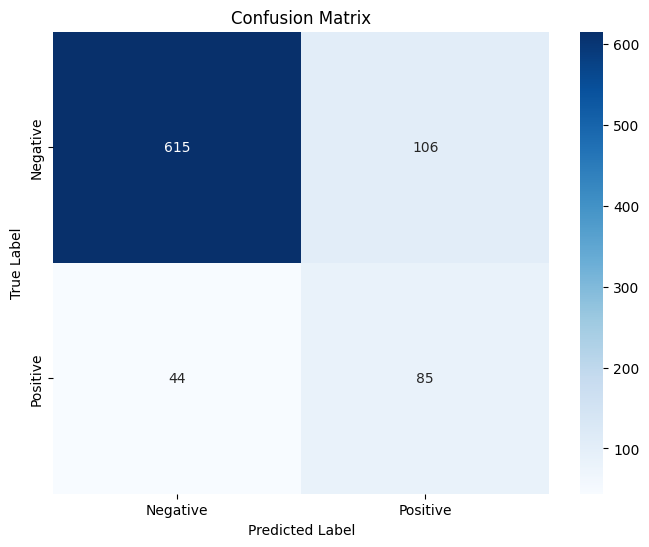

In [56]:
# Vẽ biểu đồ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_log.score(X_test, y_test) #Accuracy

0.8247058823529412

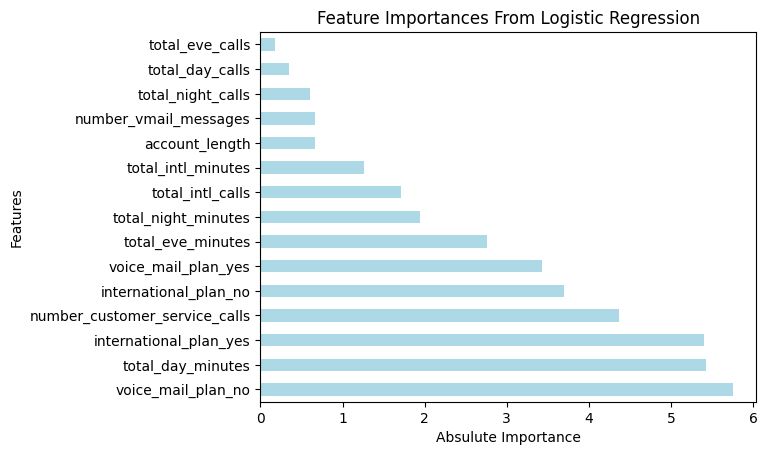

In [47]:
importance = model_log.coef_[0]
feature_names = X.columns
importance_df = pd.DataFrame({
    'Features': feature_names
  , 'Importance': importance
  ,'Absulute Importance':abs(importance)})
importance_df = importance_df.sort_values('Absulute Importance', ascending=False)
importance_df.plot(kind="barh", x="Features", y="Absulute Importance", color='lightblue', legend=False)
plt.title('Feature Importances From Logistic Regression')
plt.xlabel('Absulute Importance')
plt.show()

#Sử dungg Gradient Boosting Classifier

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbc = GradientBoostingClassifier(learning_rate= 0.01, random_state=42)
model_gbc.fit(X_train, y_train)
y_pred = model_gbc.predict(X_test)

# In ra du lieu
print(classification_report( y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       721
           1       0.00      0.00      0.00       129

    accuracy                           0.85       850
   macro avg       0.42      0.50      0.46       850
weighted avg       0.72      0.85      0.78       850



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Sử dụng XGBoost

In [51]:
# XGBoost

import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 100)
model_xgb.fit(X_train_resample, y_train_resample)


y_pred = model_xgb.predict(X_test)
# In bao cao ket qua
print(classification_report( y_test, y_pred))
#confusion_matrix(model_xgb, X_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       721
           1       0.84      0.81      0.83       129

    accuracy                           0.95       850
   macro avg       0.90      0.89      0.90       850
weighted avg       0.95      0.95      0.95       850



In [ ]:
y_pred.predict()

In [52]:
#Xây dựng cây quyết định
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

tree = DecisionTreeClassifier()
tree.fit(X_train_resample, y_train_resample)

y_pred = tree.predict(X_test)
# In bao cao ket qua
print(classification_report( y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       721
           1       0.68      0.81      0.73       129

    accuracy                           0.91       850
   macro avg       0.82      0.87      0.84       850
weighted avg       0.92      0.91      0.91       850



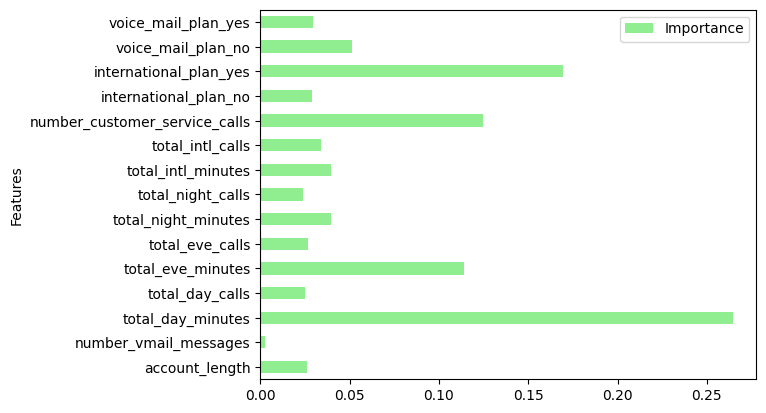

In [55]:
feature_importances = tree.feature_importances_
importance_df = pd.DataFrame({'Features': X_train.columns, 'Importance': feature_importances})
importance_df.sort_values('Importance', ascending=False)
importance_df.plot(kind="barh", x="Features", y="Importance", color='lightgreen')
plt.show()

In [ ]:
from google.colab import files

# Tải tệp cụ thể về máy tính
files.download('path/to/your/file')